In [1]:
#import dependecies
import pandas as pd
import sqlite3
import warnings
warnings.filterwarnings('ignore')

import datetime
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

#import dependencies for ML models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVR
from sklearn.model_selection import validation_curve
import math
from math import sqrt


#import dependencies for graphs
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats
import seaborn as sns; sns.set_theme(color_codes=True)
sns.set_context("poster")


In [2]:
#connect to a sqlite3 db
conn = sqlite3.connect(r'/Users/rosaicelaroman/Desktop/portfolio_work/earthquake_modeling/Database/db/earthquake_db')
print("Connected to database...")

Connected to database...


In [3]:
#create dataframe reading all rows from sqlite database
model_df = pd.read_sql_query("SELECT * FROM earthquake_raw", conn)
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06T01:42:39.855Z,37.384000,-117.107500,1.10,1.30,ml,8.0,149.46,0.87500,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.1,0.290,4.0,automatic,nn,nn
1,2022-01-06T01:31:33.698Z,38.181000,-117.818000,7.30,1.40,ml,11.0,154.64,0.11900,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.0,0.460,5.0,automatic,nn,nn
2,2022-01-06T01:24:20.083Z,61.340700,-149.885200,30.00,1.50,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.2,NaN,NaN,automatic,ak,ak
3,2022-01-06T01:15:15.851Z,62.870300,-150.762500,111.30,2.10,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.8,NaN,NaN,automatic,ak,ak
4,2022-01-06T01:10:44.629Z,64.014500,-148.765700,1.90,1.50,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.6,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58103,2022-05-10T18:52:32.159Z,-27.668500,-176.934500,25.08,4.60,mb,NaN,76.00,1.80900,0.7400,...,2022-05-31T22:12:12.040Z,Kermadec Islands region,earthquake,10.1,3.7,0.100,34.0,reviewed,us,us
58104,2022-05-10T18:49:23.310Z,-59.013100,-25.575000,55.95,4.90,mb,NaN,65.00,7.65300,0.6000,...,2022-05-31T19:19:19.040Z,South Sandwich Islands region,earthquake,11.6,4.4,0.099,32.0,reviewed,us,us
58105,2022-05-10T16:40:16.050Z,34.731833,-119.073333,11.19,0.83,ml,8.0,168.00,0.02522,0.1500,...,2022-06-07T17:55:46.520Z,"14km SSE of Pine Mountain Club, CA",earthquake,0.5,0.9,0.211,2.0,reviewed,ci,ci
58106,2022-05-10T08:28:40.129Z,2.945500,128.323100,53.98,4.50,mb,NaN,100.00,2.36100,0.8200,...,2022-06-06T07:24:34.040Z,"139 km NNE of Tobelo, Indonesia",earthquake,7.0,7.8,0.111,24.0,reviewed,us,us


In [4]:
#converting time to datetime
model_df['time'] = pd.to_datetime(model_df['time'])
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06 01:42:39.855000+00:00,37.384000,-117.107500,1.10,1.30,ml,8.0,149.46,0.87500,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.1,0.290,4.0,automatic,nn,nn
1,2022-01-06 01:31:33.698000+00:00,38.181000,-117.818000,7.30,1.40,ml,11.0,154.64,0.11900,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.0,0.460,5.0,automatic,nn,nn
2,2022-01-06 01:24:20.083000+00:00,61.340700,-149.885200,30.00,1.50,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.2,NaN,NaN,automatic,ak,ak
3,2022-01-06 01:15:15.851000+00:00,62.870300,-150.762500,111.30,2.10,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.8,NaN,NaN,automatic,ak,ak
4,2022-01-06 01:10:44.629000+00:00,64.014500,-148.765700,1.90,1.50,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.6,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58103,2022-05-10 18:52:32.159000+00:00,-27.668500,-176.934500,25.08,4.60,mb,NaN,76.00,1.80900,0.7400,...,2022-05-31T22:12:12.040Z,Kermadec Islands region,earthquake,10.1,3.7,0.100,34.0,reviewed,us,us
58104,2022-05-10 18:49:23.310000+00:00,-59.013100,-25.575000,55.95,4.90,mb,NaN,65.00,7.65300,0.6000,...,2022-05-31T19:19:19.040Z,South Sandwich Islands region,earthquake,11.6,4.4,0.099,32.0,reviewed,us,us
58105,2022-05-10 16:40:16.050000+00:00,34.731833,-119.073333,11.19,0.83,ml,8.0,168.00,0.02522,0.1500,...,2022-06-07T17:55:46.520Z,"14km SSE of Pine Mountain Club, CA",earthquake,0.5,0.9,0.211,2.0,reviewed,ci,ci
58106,2022-05-10 08:28:40.129000+00:00,2.945500,128.323100,53.98,4.50,mb,NaN,100.00,2.36100,0.8200,...,2022-06-06T07:24:34.040Z,"139 km NNE of Tobelo, Indonesia",earthquake,7.0,7.8,0.111,24.0,reviewed,us,us


In [5]:
#adding column of converted time to datetime
model_df['Unix Time'] = pd.to_datetime(model_df['time']).astype(int)/10**9
model_df.head(5)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,Unix Time
0,2022-01-06 01:42:39.855000+00:00,37.3840,-117.1075,1.1,1.3,ml,8.0,149.46,0.875,0.2175,...,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.1,0.29,4.0,automatic,nn,nn,1.641433e+09
1,2022-01-06 01:31:33.698000+00:00,38.1810,-117.8180,7.3,1.4,ml,11.0,154.64,0.119,0.1017,...,"34 km SE of Mina, Nevada",earthquake,NaN,2.0,0.46,5.0,automatic,nn,nn,1.641433e+09
2,2022-01-06 01:24:20.083000+00:00,61.3407,-149.8852,30.0,1.5,ml,NaN,NaN,NaN,0.7500,...,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.2,NaN,NaN,automatic,ak,ak,1.641432e+09
3,2022-01-06 01:15:15.851000+00:00,62.8703,-150.7625,111.3,2.1,ml,NaN,NaN,NaN,0.3200,...,"41 km N of Petersville, Alaska",earthquake,NaN,0.8,NaN,NaN,automatic,ak,ak,1.641432e+09
4,2022-01-06 01:10:44.629000+00:00,64.0145,-148.7657,1.9,1.5,ml,NaN,NaN,NaN,0.7200,...,"17 km E of Ferry, Alaska",earthquake,NaN,0.6,NaN,NaN,automatic,ak,ak,1.641431e+09


In [6]:
#review names of all columns (features)
for col in model_df.columns:
    print(col)

time
latitude
longitude
depth
mag
magType
nst
gap
dmin
rms
net
id
updated
place
type
horizontalError
depthError
magError
magNst
status
locationSource
magSource
Unix Time


In [7]:
#drop columns not needed
cleaned_df = model_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_df

,latitude,longitude,depth,mag,Unix Time
0,37.384000,-117.107500,1.10,1.30,1.641433e+09
1,38.181000,-117.818000,7.30,1.40,1.641433e+09
2,61.340700,-149.885200,30.00,1.50,1.641432e+09
3,62.870300,-150.762500,111.30,2.10,1.641432e+09
4,64.014500,-148.765700,1.90,1.50,1.641431e+09
...,...,...,...,...,...
58103,-27.668500,-176.934500,25.08,4.60,1.652209e+09
58104,-59.013100,-25.575000,55.95,4.90,1.652209e+09
58105,34.731833,-119.073333,11.19,0.83,1.652201e+09
58106,2.945500,128.323100,53.98,4.50,1.652171e+09


In [8]:
#find if any column has NaNs
cleaned_df.isnull().sum()

latitude     0
longitude    0
depth        0
mag          6
Unix Time    0
dtype: int64

In [9]:
#drop NaNs
cleaned_df_dropped = cleaned_df.dropna()

In [10]:
#verify dropped NaNs
cleaned_df_dropped.isnull().sum()

latitude     0
longitude    0
depth        0
mag          0
Unix Time    0
dtype: int64

In [11]:
#establish features to be used in model. X will use: longitude, depth, mag and unix time. Y will be latitude
X = cleaned_df_dropped.drop(['latitude'], axis = 1)

y = cleaned_df_dropped[['latitude']]

In [12]:
#checking number of columns and rows for eacg feature
X.shape, y.shape

((58102, 4), (58102, 1))

In [13]:
#split dataset into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

Extra Trees Regressor

In [14]:
#create and run model: First with 50 estimators
scores = []
estimators_lst=[]

for i in range(1,50):
    model = ExtraTreesRegressor(n_estimators=i+1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)

    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    estimators = i+1
    scores.append(score)
    estimators_lst.append(score)

    print("n_estimators={}:".format(estimators))
    print("\tMean Squared Error:", mse, end = ", ")
    print("\tR2 score:", r2, end = ", ")
    print("\tModel score:", score)
max_score = max(scores)
print("Max score:", max_score)
index_max_score = scores.index(max_score) #find the position in the list for max score to get the number of estimators
best_score = max_score
best_model = ExtraTreesRegressor(n_estimators=index_max_score+2, random_state=0)
best_model.fit(X_train, y_train)
best_model_score = best_model.score(X_test, y_test)
print("Best model score: ", best_model_score)


n_estimators=2:
	Mean Squared Error: 67.05026918385698, 	R2 score: 0.8384502964169755, 	Model score: 0.8384502964169755
n_estimators=3:
	Mean Squared Error: 55.99000285146246, 	R2 score: 0.865098701700005, 	Model score: 0.865098701700005
n_estimators=4:
	Mean Squared Error: 50.993575382988354, 	R2 score: 0.8771370035044728, 	Model score: 0.8771370035044728
n_estimators=5:
	Mean Squared Error: 47.83054924796951, 	R2 score: 0.8847579413583759, 	Model score: 0.8847579413583759
n_estimators=6:
	Mean Squared Error: 45.732663529078714, 	R2 score: 0.8898125491946032, 	Model score: 0.8898125491946032
n_estimators=7:
	Mean Squared Error: 44.75479826865475, 	R2 score: 0.8921686000336005, 	Model score: 0.8921686000336005
n_estimators=8:
	Mean Squared Error: 44.01731745803171, 	R2 score: 0.8939454729351489, 	Model score: 0.8939454729351489
n_estimators=9:
	Mean Squared Error: 43.622210390280706, 	R2 score: 0.8948974367446261, 	Model score: 0.8948974367446261
n_estimators=10:
	Mean Squared Error: 4

In [15]:
#create and run model: Now with 100 max estimators if no improvement of the score is found
scores = []
counter = 0
import time
start_time = time.perf_counter()
for i in range(1,80):
    model = ExtraTreesRegressor(n_estimators=i+1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)

    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    estimators = i+1
    current_score = score
    num_estimators = estimators

    print("n_estimators={}:".format(estimators))
    print("\tMean Squared Error:", mse, end = ", ")
    print("\tR2:", r2, end = ", ")
    print("\tModel score:", score)
    if current_score > best_score:
        best_score = current_score
        best_model = model
        num_estimators=i+1
        print('Improvement found!')
        counter = 0
    else:
        counter += 1
    if counter > 60:
        break

end_time = time.perf_counter()
execution_time = end_time - start_time

print(f'Best score found: {best_score:.3f}.')
print(f'Number of estimators: {num_estimators}.')
print(f'Code execution time: {execution_time:.3f} seconds.')

n_estimators=2:
	Mean Squared Error: 67.05026918385698, 	R2: 0.8384502964169755, 	Model score: 0.8384502964169755
n_estimators=3:
	Mean Squared Error: 55.99000285146246, 	R2: 0.865098701700005, 	Model score: 0.865098701700005
n_estimators=4:
	Mean Squared Error: 50.993575382988354, 	R2: 0.8771370035044728, 	Model score: 0.8771370035044728
n_estimators=5:
	Mean Squared Error: 47.83054924796951, 	R2: 0.8847579413583759, 	Model score: 0.8847579413583759
n_estimators=6:
	Mean Squared Error: 45.732663529078714, 	R2: 0.8898125491946032, 	Model score: 0.8898125491946032
n_estimators=7:
	Mean Squared Error: 44.75479826865475, 	R2: 0.8921686000336005, 	Model score: 0.8921686000336005
n_estimators=8:
	Mean Squared Error: 44.01731745803171, 	R2: 0.8939454729351489, 	Model score: 0.8939454729351489
n_estimators=9:
	Mean Squared Error: 43.622210390280706, 	R2: 0.8948974367446261, 	Model score: 0.8948974367446261
n_estimators=10:
	Mean Squared Error: 42.90394992686452, 	R2: 0.8966280004898978, 	Mode

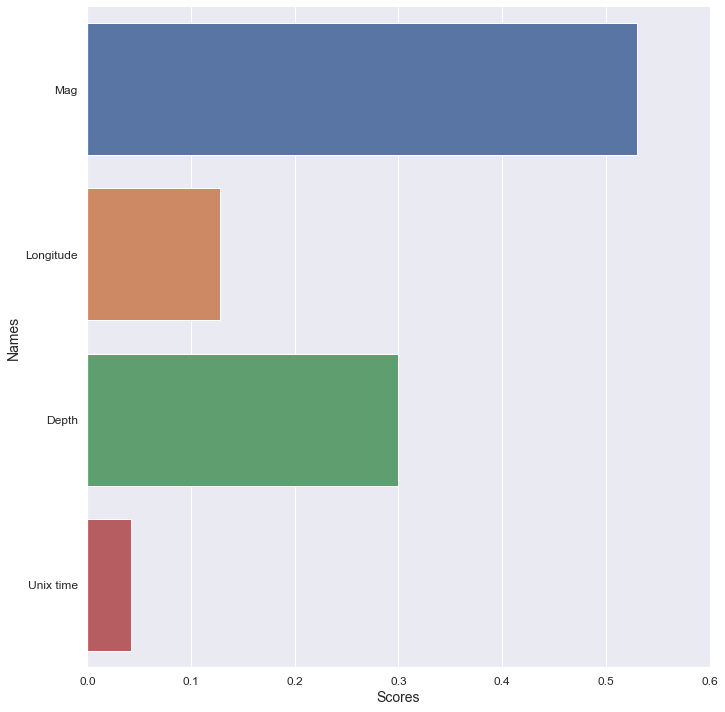

In [16]:
#visualize gini importance
features_lst = []
gini_score_lst = []
for feature, score in zip(cleaned_df_dropped[['mag', 'longitude', 'depth', 'Unix Time']],best_model.feature_importances_):
    features_lst.append(feature)
    gini_score_lst.append(score)
feature_lst = [feature.capitalize() for feature in features_lst]
d = {'Names': feature_lst, 'Scores': gini_score_lst}
gini_df = pd.DataFrame(d)

sns.set()

p = sns.catplot(y='Names', x="Scores", data=gini_df, kind='bar', height=10, aspect=1, legend=False)
p.set_ylabels(fontsize=14)
p.set_yticklabels(fontsize=12)
p.set_xticklabels(fontsize=12)
p.set_xlabels(fontsize=14)
plt.show()

Cross-Validation

In [17]:
#define number of splits for cross-validation
k_fold = KFold(n_splits=10)
for train_indices, test_indices in k_fold.split(X):
    print('Train: %s | test: %s' % (train_indices, test_indices))


Train: [ 5811  5812  5813 ... 58099 58100 58101] | test: [   0    1    2 ... 5808 5809 5810]
Train: [    0     1     2 ... 58099 58100 58101] | test: [ 5811  5812  5813 ... 11619 11620 11621]
Train: [    0     1     2 ... 58099 58100 58101] | test: [11622 11623 11624 ... 17429 17430 17431]
Train: [    0     1     2 ... 58099 58100 58101] | test: [17432 17433 17434 ... 23239 23240 23241]
Train: [    0     1     2 ... 58099 58100 58101] | test: [23242 23243 23244 ... 29049 29050 29051]
Train: [    0     1     2 ... 58099 58100 58101] | test: [29052 29053 29054 ... 34859 34860 34861]
Train: [    0     1     2 ... 58099 58100 58101] | test: [34862 34863 34864 ... 40669 40670 40671]
Train: [    0     1     2 ... 58099 58100 58101] | test: [40672 40673 40674 ... 46479 46480 46481]
Train: [    0     1     2 ... 58099 58100 58101] | test: [46482 46483 46484 ... 52289 52290 52291]
Train: [    0     1     2 ... 52289 52290 52291] | test: [52292 52293 52294 ... 58099 58100 58101]


In [18]:
#calculate cross-validation score
from numpy import mean
from numpy import std

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cv_score=cross_val_score(best_model, X, y.values.ravel(), scoring='neg_mean_absolute_error', cv=k_fold, n_jobs=-1)
    print(cv_score)

# report performance
print('MAE: %.3f (%.3f)' % (mean(cv_score), std(cv_score)))

[-2.03820869 -2.22426671 -2.15635043 -2.06376696 -2.20799212 -2.11640516
 -1.81934364 -1.84708702 -2.07601382 -2.37806255]
MAE: -2.093 (0.160)


In [19]:
#define tree for plot validation curve
reg_etrees = ExtraTreesRegressor(n_estimators=100, random_state=0)

In [20]:
#create elements for plot validation curve
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
param_range = np.linspace(1, 100, 5, dtype=int)
train_scores, test_scores = validation_curve(
    reg_etrees,
    X,
    y.values.ravel(),
    param_name="n_estimators",
    param_range=param_range,
    n_jobs=2,
    cv=10
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

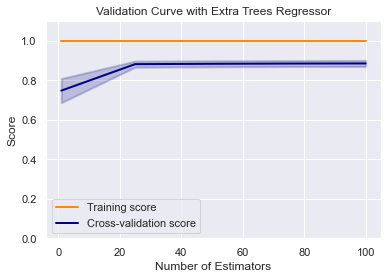

In [21]:
#plot validation curve
plt.title("Validation Curve with Extra Trees Regressor")
plt.xlabel("Number of Estimators")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.plot(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

In [22]:
#use the best model to make predictions
testpred = best_model.predict(X_test)
actual_lat = y_test
lats = actual_lat['latitude'].tolist()
testpredict = []
abs_error = []
for item in testpred:
    testpredict.append(item)

maerr=mean_absolute_error(lats, testpredict)
test_mse = mean_squared_error(y_test, testpred)
rmse = sqrt(test_mse)
print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % maerr)

RMSE: 6.343
MAE: 1.814


In [23]:
#make dataframe with actual test values and ML predicted ones
lat_pred = actual_lat
lat_pred['Predicted'] = testpredict


In [24]:
lat_pred = lat_pred.rename(columns={'latitude': 'Actual'})

In [25]:
lat_pred.head(5)

,Actual,Predicted
3616,38.819833,38.815052
13495,38.824000,38.815166
28367,38.163800,37.841158
31835,17.972500,17.964417
27553,62.942500,62.909069


In [26]:
#join dataframes for actual and predicted with original dataframe
lat_pred_all = lat_pred.merge(model_df, how='inner', left_index=True, right_index=True)
lat_pred_all.head(5)

,Actual,Predicted,time,latitude,longitude,depth,mag,magType,nst,gap,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,Unix Time
3616,38.819833,38.815052,2021-12-22 11:53:28.400000+00:00,38.819833,-122.790667,1.25,1.14,md,43.0,26.00,...,"6km NNW of The Geysers, CA",earthquake,0.13,0.21,0.209000,10.0,reviewed,nc,nc,1.640174e+09
13495,38.824000,38.815166,2022-01-07 02:47:48.980000+00:00,38.824000,-122.763167,0.95,0.08,md,14.0,89.00,...,"4km W of Cobb, CA",earthquake,0.27,0.40,0.222000,3.0,reviewed,nc,nc,1.641524e+09
28367,38.163800,37.841158,2022-02-18 05:32:12.402000+00:00,38.163800,-117.914700,10.20,2.70,ml,22.0,103.56,...,"30 km SE of Mina, Nevada",earthquake,NaN,0.70,0.230000,9.0,reviewed,nn,nn,1.645162e+09
31835,17.972500,17.964417,2022-03-13 14:58:22.200000+00:00,17.972500,-66.977667,12.28,2.06,md,3.0,180.00,...,"6 km WSW of Fuig, Puerto Rico",earthquake,2.33,1.10,0.038064,3.0,reviewed,pr,pr,1.647184e+09
27553,62.942500,62.909069,2022-02-20 07:26:28.782000+00:00,62.942500,-151.285700,110.80,2.00,ml,NaN,NaN,...,"56 km NNW of Petersville, Alaska",earthquake,NaN,1.00,NaN,NaN,automatic,ak,ak,1.645342e+09


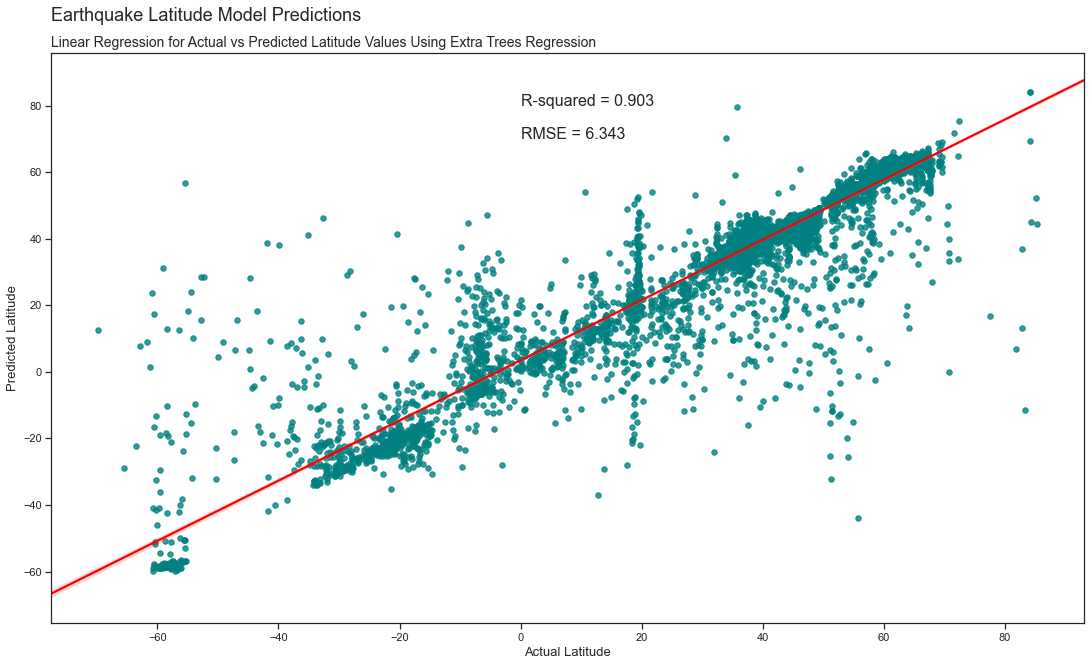

In [27]:
#plot actual vs predicted values
x = np.array(lat_pred_all['latitude'])
y = np.array(testpredict)


sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'teal'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Latitude', fontsize=13)
plt.xlabel('Actual Latitude',  fontsize=13)
# Bigger title
plt.suptitle('Earthquake Latitude Model Predictions', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted Latitude Values Using Extra Trees Regression', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(lat_pred_all['latitude'], testpredict)), (0, 80),  fontsize=16)
plt.annotate("RMSE = {:.3f}".format(rmse), (0, 70), fontsize=16)

fig.savefig('../static/images/extratrees_lat_linear_sns.png', bbox_inches='tight',dpi=600)
plt.show()

In [28]:
# make a single prediction
from datetime import datetime
mag = float(input('Enter a magnitude: '))
lon = float(input('Enter a longitude (in decimal form; negative for west of meridian): '))
depth = float(input('Enter a depth (in km, only numerical value): '))
date_input = input('Enter a date (yyyy/mm/dd): ')
time_input = input('Enter a time in UTC (HH:MM:SS): ')
datetime_str = date_input + ' '+ time_input
date_time_obj = datetime.strptime(datetime_str, '%Y/%m/%d %H:%M:%S')
date_time_unix = (time.mktime(date_time_obj.timetuple()))
single_features = [[mag,lon,depth,date_time_unix]]
y_pred = best_model.predict(single_features)
print('Predicted Latitude: %g' % y_pred)

Predicted Latitude: 27.1807


Test with new data from USGS


In [29]:
#obtain USGS data for the day
page_url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_day.csv"

test_df = pd.read_csv(page_url)
test_df


,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-07-09T20:32:54.760Z,38.836498,-122.811500,1.79,0.36,md,8.0,83.0,0.013130,0.01,...,2022-07-09T20:42:11.244Z,"8km WNW of Cobb, CA",earthquake,0.37,0.89,NaN,1.0,automatic,nc,nc
1,2022-07-09T20:31:04.548Z,62.335900,-149.726300,31.10,3.40,ml,NaN,NaN,NaN,1.07,...,2022-07-09T20:39:47.811Z,"19 km E of Talkeetna, Alaska",earthquake,NaN,0.40,NaN,NaN,automatic,ak,ak
2,2022-07-09T20:27:45.820Z,32.833500,-115.600333,5.88,1.51,ml,18.0,98.0,0.109100,0.22,...,2022-07-09T20:31:22.656Z,"3km WSW of Imperial, CA",earthquake,0.49,1.06,0.150,27.0,automatic,ci,ci
3,2022-07-09T20:17:20.060Z,35.927833,-117.654333,2.14,2.05,ml,23.0,63.0,0.043430,0.19,...,2022-07-09T20:28:13.310Z,"23km E of Little Lake, CA",earthquake,0.25,0.39,0.114,26.0,automatic,ci,ci
4,2022-07-09T19:56:33.020Z,38.835499,-122.799332,2.16,1.45,md,24.0,63.0,0.007597,0.02,...,2022-07-09T20:13:13.063Z,"7km WNW of Cobb, CA",earthquake,0.20,0.43,0.120,5.0,automatic,nc,nc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-07-08T20:59:17.400Z,39.431833,-110.312167,-1.00,1.66,md,6.0,194.0,0.012650,0.10,...,2022-07-08T22:05:36.770Z,"14 km SSE of Sunnyside, Utah",earthquake,1.22,0.51,0.203,6.0,reviewed,uu,uu
236,2022-07-08T20:54:51.369Z,60.891300,-149.144700,18.40,2.00,ml,NaN,NaN,NaN,1.58,...,2022-07-08T20:57:18.946Z,"5 km SSE of Girdwood, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak
237,2022-07-08T20:51:51.150Z,39.434333,-110.327000,-1.01,1.55,md,6.0,154.0,0.010330,0.03,...,2022-07-08T21:50:10.700Z,"14 km SSE of Sunnyside, Utah",earthquake,0.88,0.28,0.076,5.0,reviewed,uu,uu
238,2022-07-08T20:46:12.073Z,19.017000,147.062600,10.00,5.00,mb,107.0,130.0,5.793000,0.87,...,2022-07-09T18:55:47.570Z,Mariana Islands region,earthquake,7.70,1.80,0.053,117.0,reviewed,us,us


In [30]:
#create unix time column and drop columns not needed

test_df['Unix Time'] = pd.to_datetime(test_df['time']).astype(int)/10**9
cleaned_test_df = test_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_test_df


,latitude,longitude,depth,mag,Unix Time
0,38.836498,-122.811500,1.79,0.36,1.657399e+09
1,62.335900,-149.726300,31.10,3.40,1.657399e+09
2,32.833500,-115.600333,5.88,1.51,1.657398e+09
3,35.927833,-117.654333,2.14,2.05,1.657398e+09
4,38.835499,-122.799332,2.16,1.45,1.657397e+09
...,...,...,...,...,...
235,39.431833,-110.312167,-1.00,1.66,1.657314e+09
236,60.891300,-149.144700,18.40,2.00,1.657314e+09
237,39.434333,-110.327000,-1.01,1.55,1.657314e+09
238,19.017000,147.062600,10.00,5.00,1.657313e+09


In [31]:

#find if any column has NaNs
cleaned_test_df.isnull().sum()


latitude     0
longitude    0
depth        0
mag          0
Unix Time    0
dtype: int64

In [32]:

#establish features to be used in model. X will use: latitude, longitude, depth and unix time. Y will be magnitude
X_test_data = cleaned_test_df.drop(['latitude'], axis = 1)

y_test_data = cleaned_test_df[['latitude']]


In [33]:
#predict values with best model
pred_data_y = best_model.predict(X_test_data)


In [34]:
#create dataframe with values
test_pred_data = cleaned_test_df
test_pred_data['Predicted'] = pred_data_y
test_pred_data


,latitude,longitude,depth,mag,Unix Time,Predicted
0,38.836498,-122.811500,1.79,0.36,1.657399e+09,38.832823
1,62.335900,-149.726300,31.10,3.40,1.657399e+09,60.993281
2,32.833500,-115.600333,5.88,1.51,1.657398e+09,32.953604
3,35.927833,-117.654333,2.14,2.05,1.657398e+09,35.614183
4,38.835499,-122.799332,2.16,1.45,1.657397e+09,38.831042
...,...,...,...,...,...,...
235,39.431833,-110.312167,-1.00,1.66,1.657314e+09,39.014969
236,60.891300,-149.144700,18.40,2.00,1.657314e+09,62.383831
237,39.434333,-110.327000,-1.01,1.55,1.657314e+09,39.427719
238,19.017000,147.062600,10.00,5.00,1.657313e+09,-26.940200


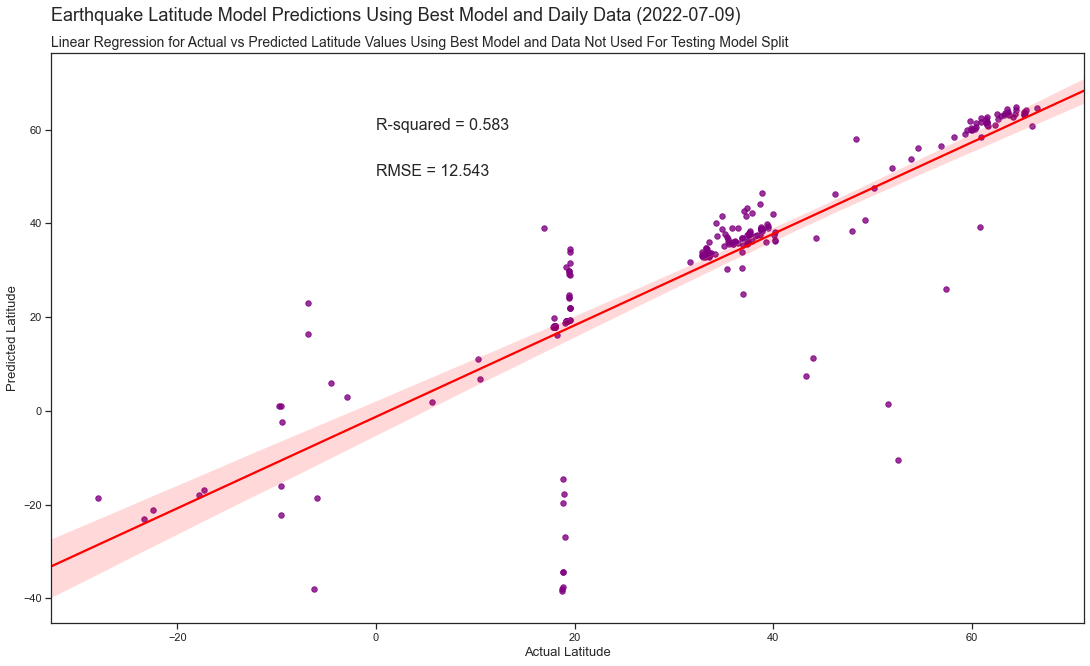

In [35]:
#create graph for actual vs predicted values
from datetime import date
today = date.today()
x = np.array(test_pred_data['latitude'])
y = np.array(pred_data_y)
test_mse = mean_squared_error(x, y)
rmse = sqrt(test_mse)

sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'purple'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Latitude', fontsize=13)
plt.xlabel('Actual Latitude',  fontsize=13)
# Bigger title
plt.suptitle(f'Earthquake Latitude Model Predictions Using Best Model and Daily Data ({today})', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted Latitude Values Using Best Model and Data Not Used For Testing Model Split', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(x, y)), (0, 60),  fontsize=16)
plt.annotate("RMSE = {:.3f}".format(rmse), (0, 50), fontsize=16)

fig.savefig('../static/images/extratrees_lat_linear_sns_daily.png', bbox_inches='tight', dpi=600)
plt.show()

In [36]:
#connection to a PostgreSQL local database
# ===========================================

# user_name_var = input('What is the username of your database? ')
host_var = input('What is the host address of your database?')
pw = input("Enter the database password: ")
# db_name = input("Enter the name of the database: ")

string_output = "postgresql://postgres"+':'+pw+'@'+host_var+":5432"+'/earthquake_db'
engine = create_engine(string_output)
connection = engine.connect()
print("Connected to database...")

Connected to database...


In [37]:
#create new database with predicted values for both training and test databases
#=============
#PostgreSQL
lat_pred_all.to_sql('earthquake_etrees_lat', engine, if_exists='replace', index = False)
#=============
#SQLite
cur = conn.cursor()
lat_pred_all.to_sql('earthquake_etrees_lat', conn, if_exists='replace', index=False)

19174

In [38]:
# Close connection to SQLite database
conn.close()
connection.close()